In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES
from anomaly.utils import line_width_from_velocity

In [3]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
metric = "mse_filter_250kms_noRel100"
# metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/"
    f"explanation/{model}/{metric}"
)

In [4]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz",
    index_col="specobjid"
)

# load the weights
explanation_weights = np.load(f"{data_directory}/weights_all_abs.npy")

In [5]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

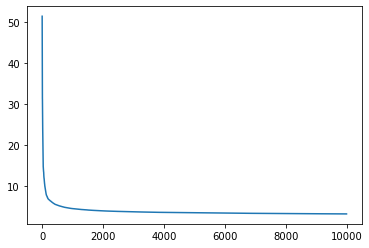

In [6]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies array as well
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

## Analyze clusters among anomalies
The clustering approach can help to gain insight into the model by grouping the anomalous spectra into clusters based on their similarity in terms of the weights assigned by the LIME algorithm. This can help identify patterns or trends in the explanations that may not be immediately apparent from the weights alone.

For example, certain clusters might have higher explanation weights for certain wavelength ranges, or certain clusters have higher explanation weights overall. This can help to understand which features of the spectra are most important for the model's predictions, and can potentially uncover new scientific insights.

Additionally, by plotting the mean spectrum and mean explanation weights for each cluster, I can get a sense of how the model is using different features of the spectra to make its predictions, and identify any patterns or trends in the model's behavior that may be relevant to the anomaly detection task.

## Analyze regions of interest

In [7]:
GALAXY_LINES.items()

dict_items([('OII_3726', 3726.04), ('H_delta_4101', 4101.734), ('H_gamma_4340', 4340.472), ('H_beta_4861', 4861.352), ('OIII_4959', 4958.911), ('OIII_5006', 5006.843), ('NII_6548', 6548.041), ('H_alpha_6562', 6562.787), ('NII_6583', 6583.461), ('SII_6716', 6716.44), ('SII_6730', 6730.812)])

In [15]:
# Define the regions of interest
regions_of_interest = {
    "H_alpha_NII": (6500, 6700),
    "H_beta_OIII": (4700, 5100),
    "OIII": (4900, 5100),
    "SII": (6650, 6800),
}

# create a dictionary to store the weights for each region
region_widths = {}
weights_per_region = {}

for region_name, (start, end) in regions_of_interest.items():

    # get the mask of the region
    region_mask = np.where(
        (wave >= start) & (wave <= end)
    )[0]

    # get the weights for the region
    weights_per_region[region_name] = (
        explanation_weights[:, region_mask], region_mask
    )
    
    # get the width of the region
    region_widths[region_name] = len(region_mask)

In [16]:
# Use a k-means clustering for each region in weights_per_region to cluster the explanations weights in 10 clusters

n_clusters = 10

kmeans_per_region = {}

for region_name, (region_w, region_mask) in weights_per_region.items():
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(region_w)

    kmeans_per_region[region_name] = (kmeans, region_mask)


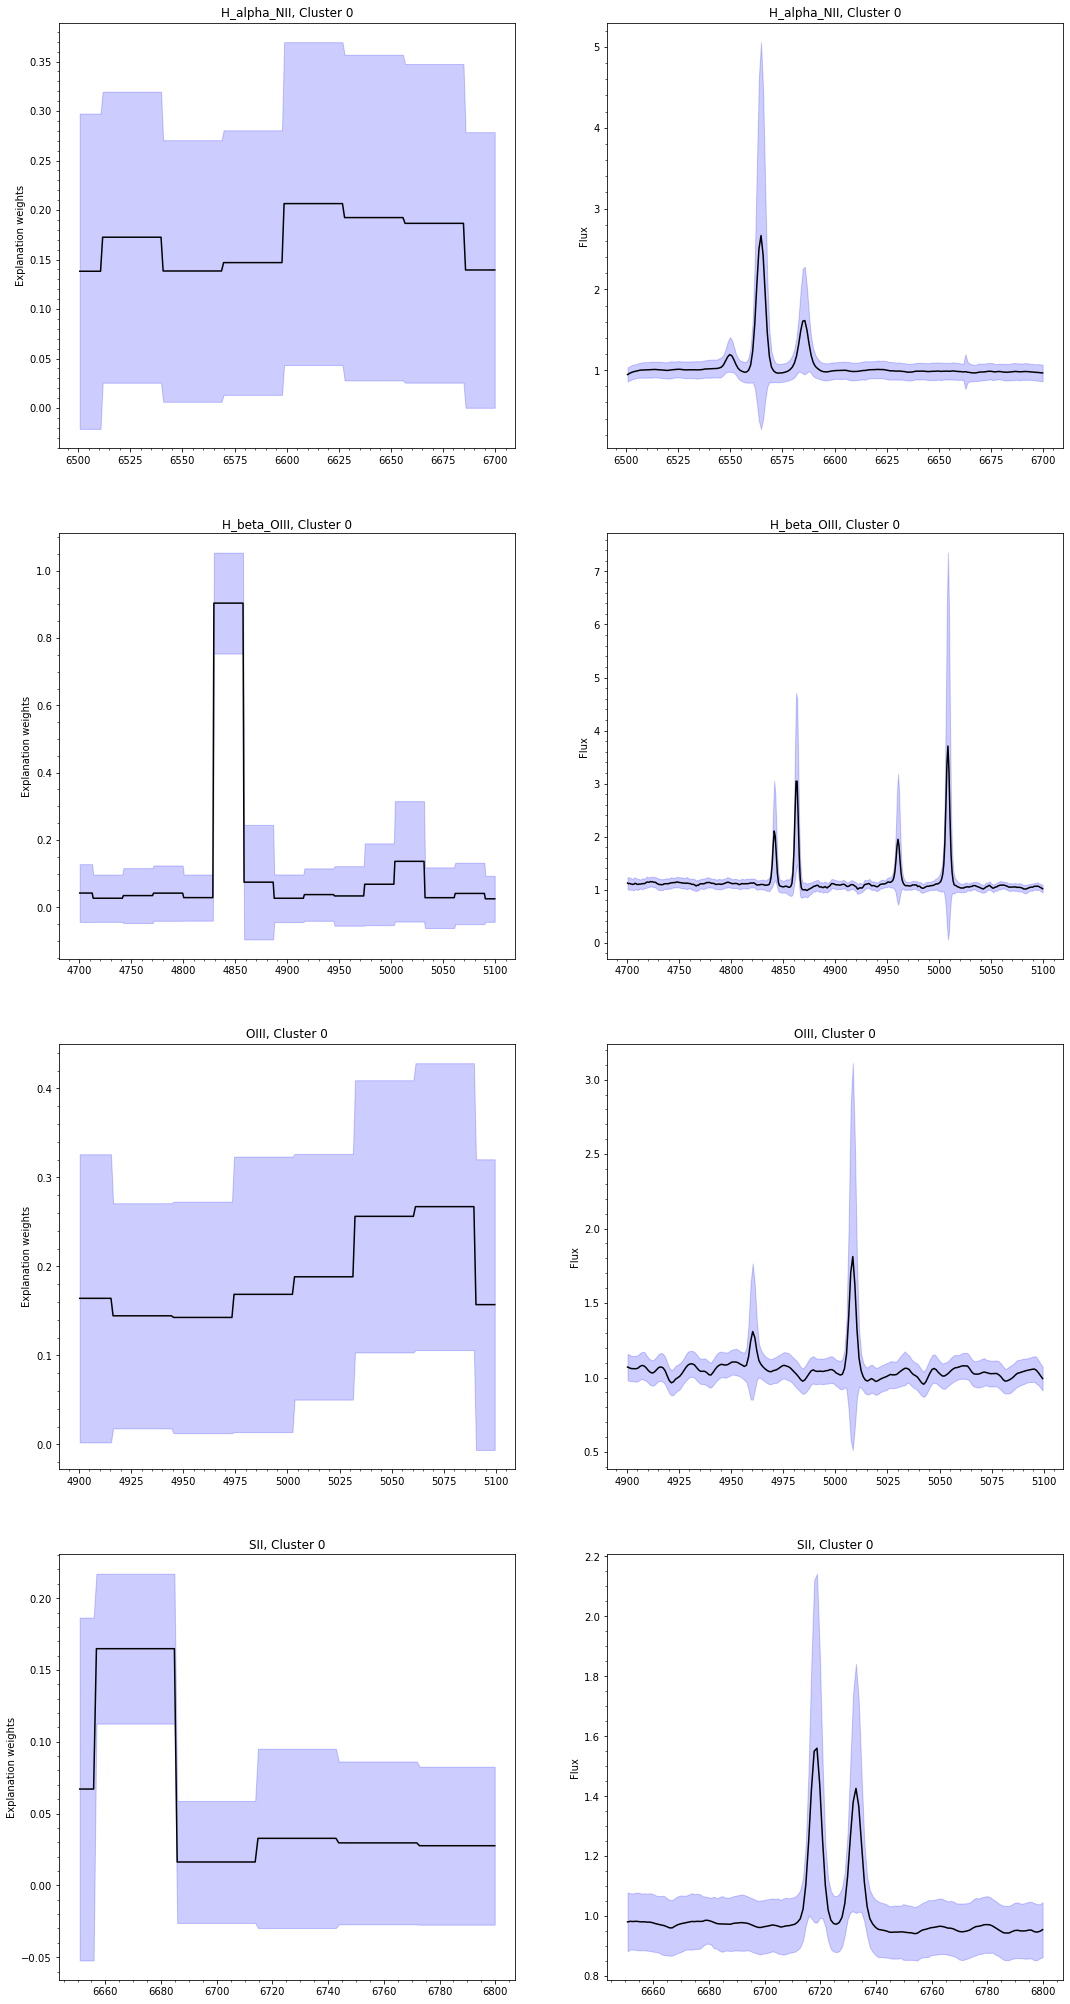

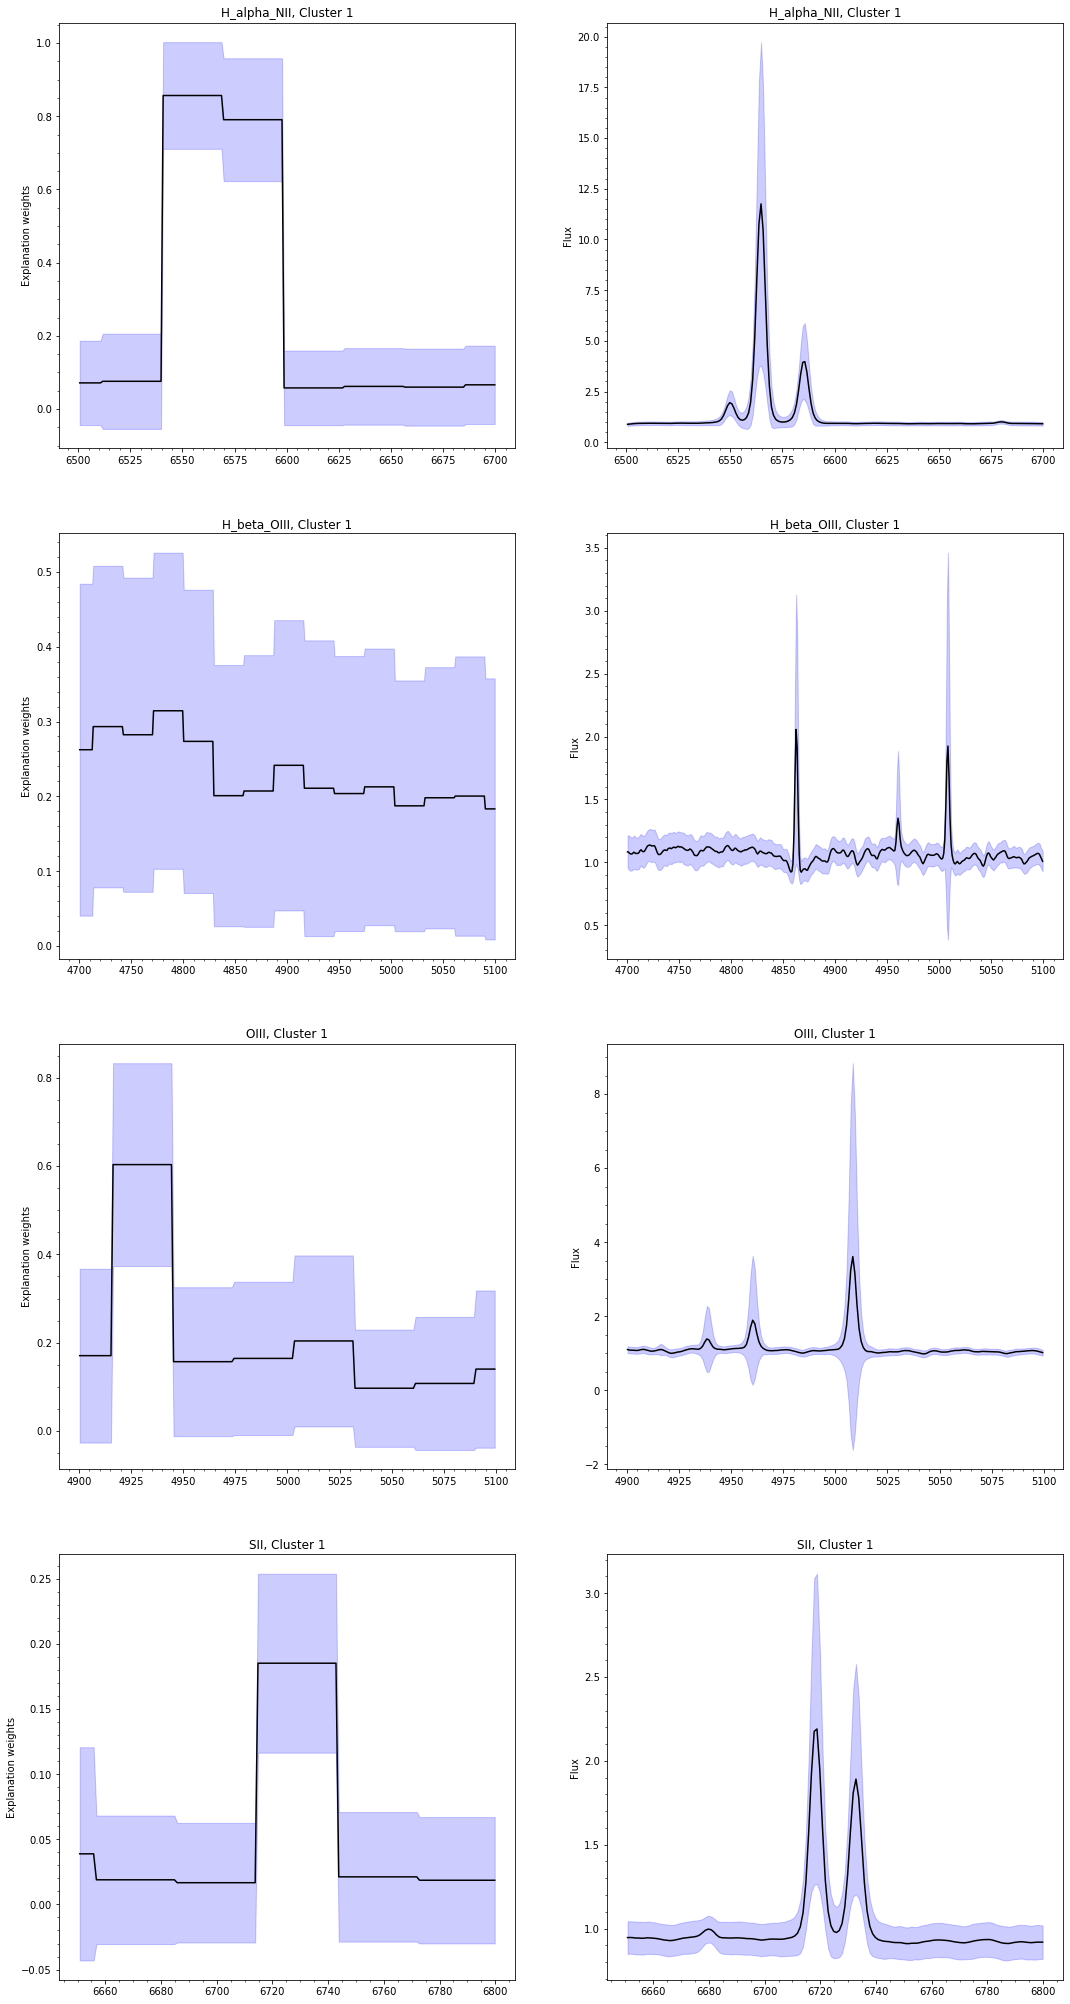

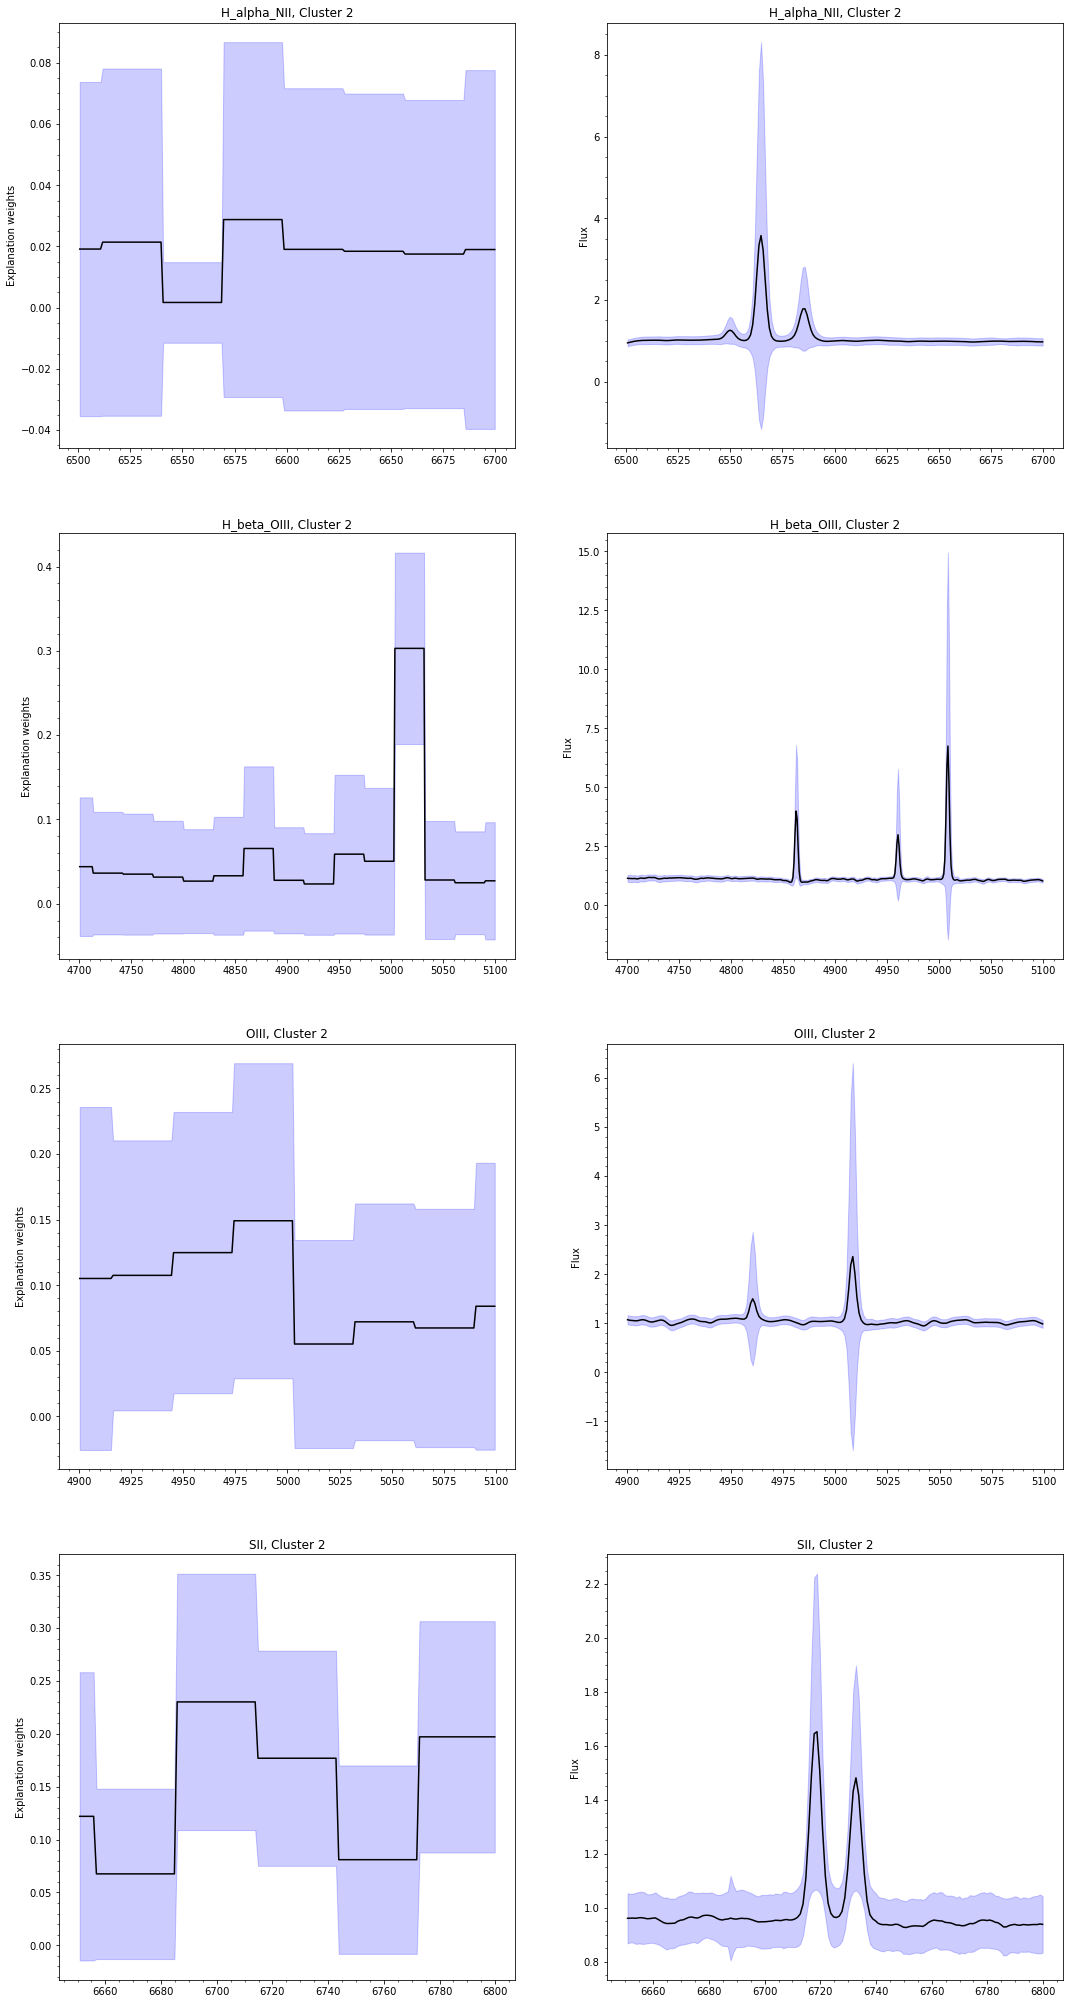

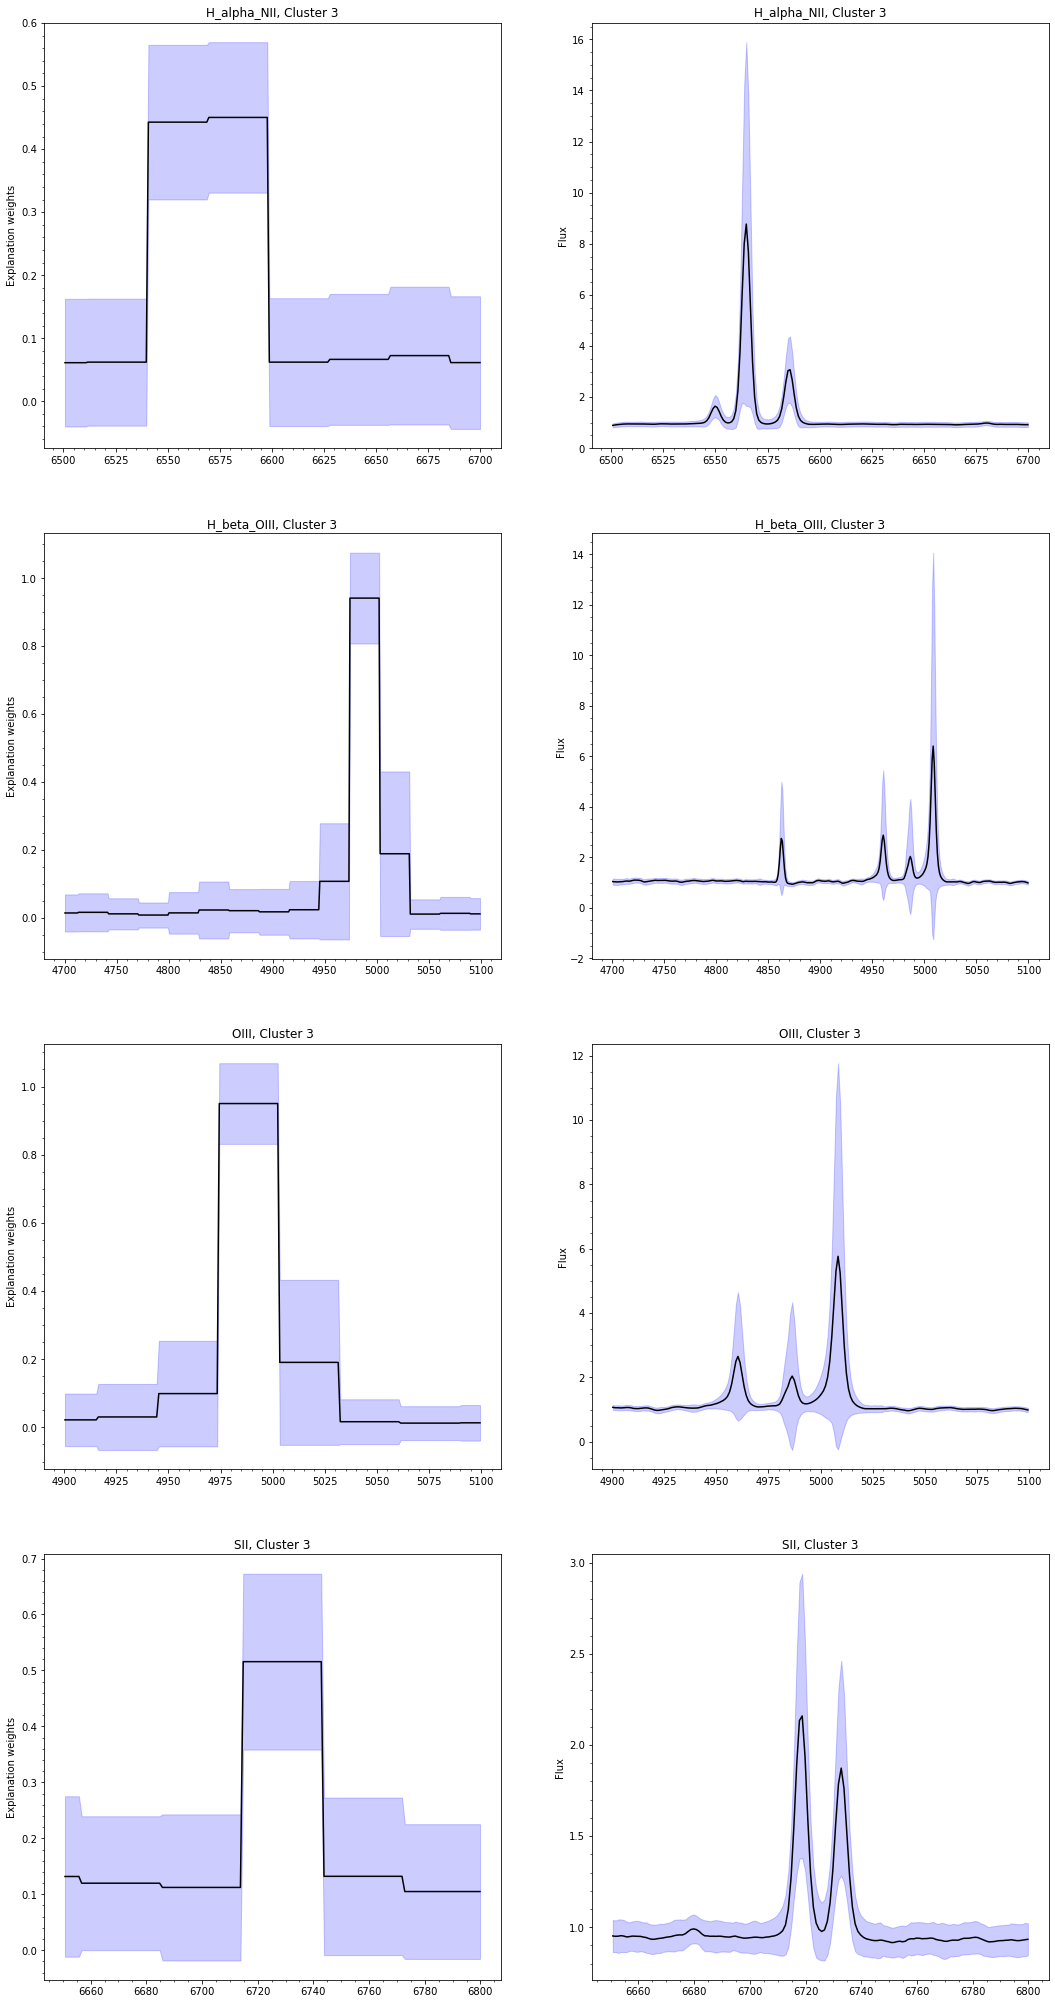

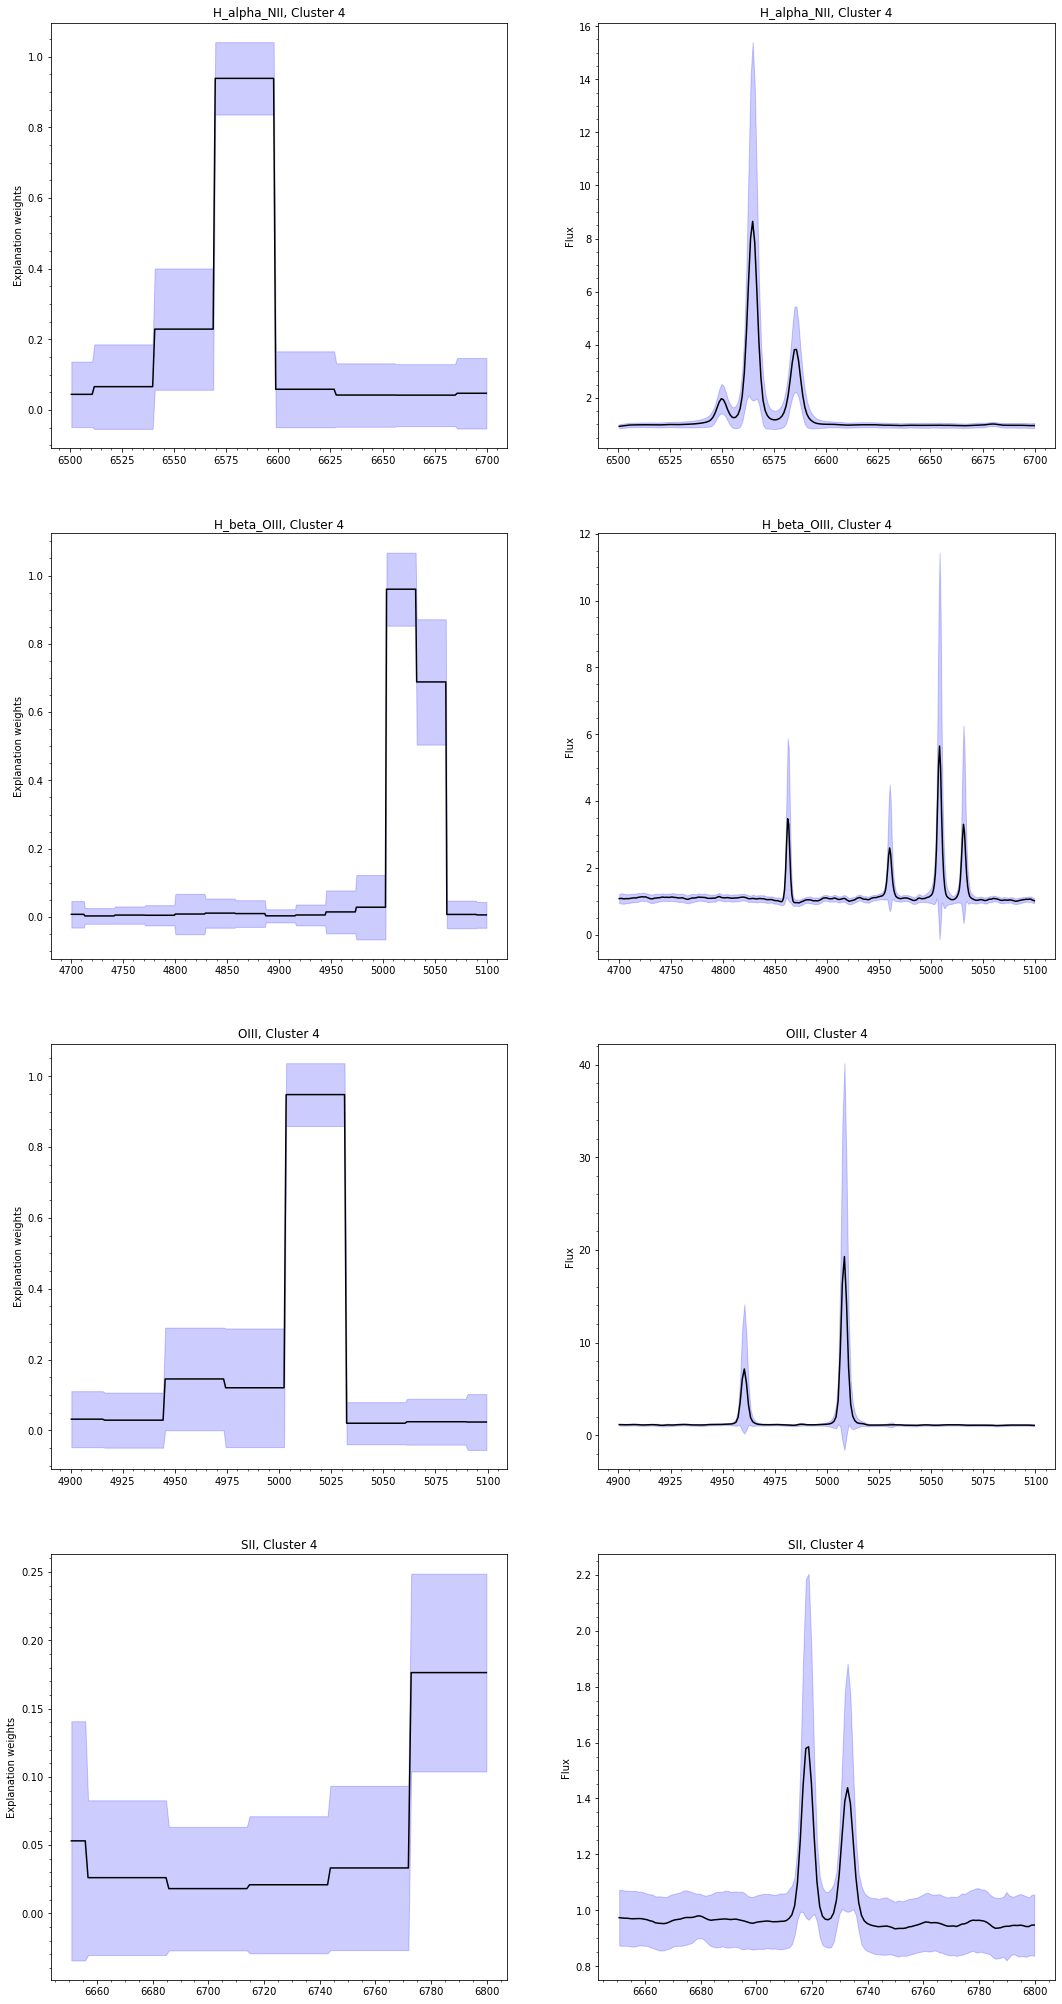

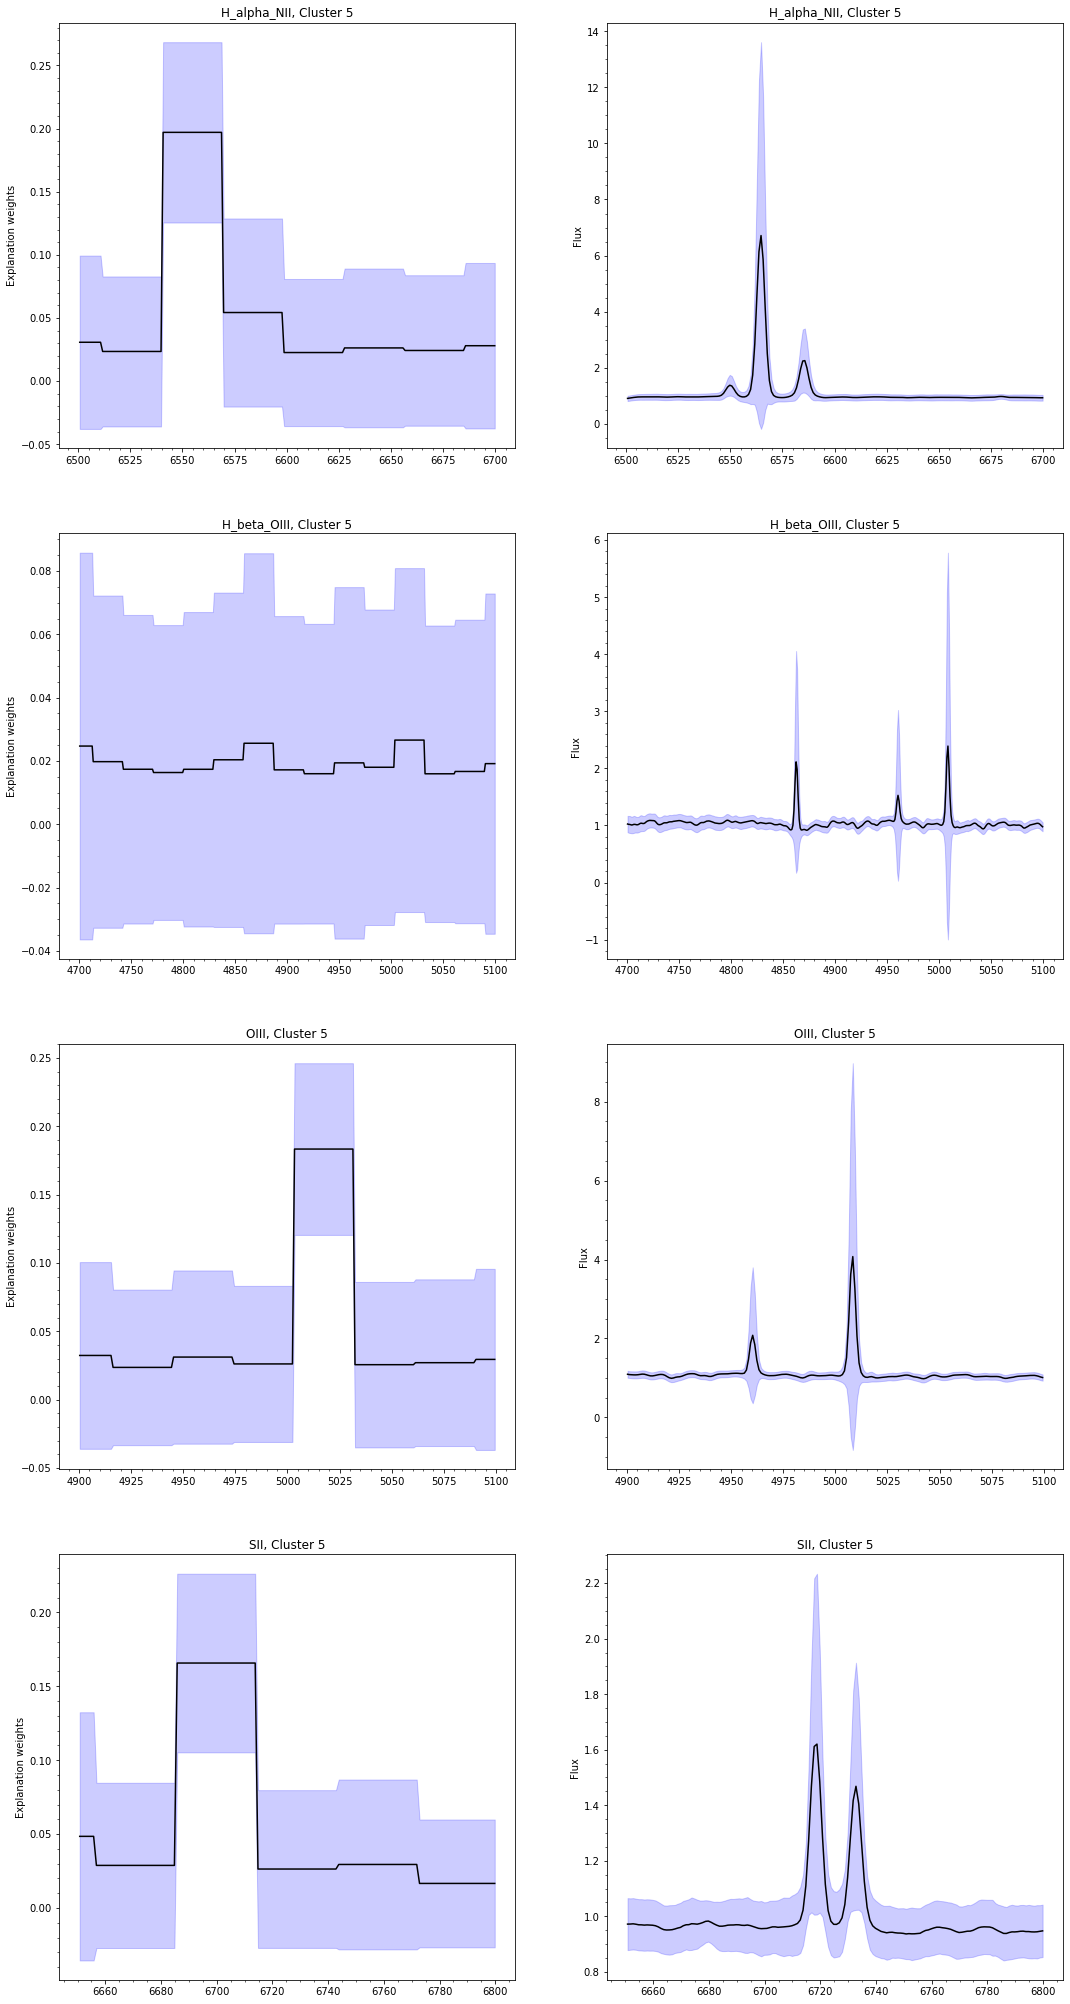

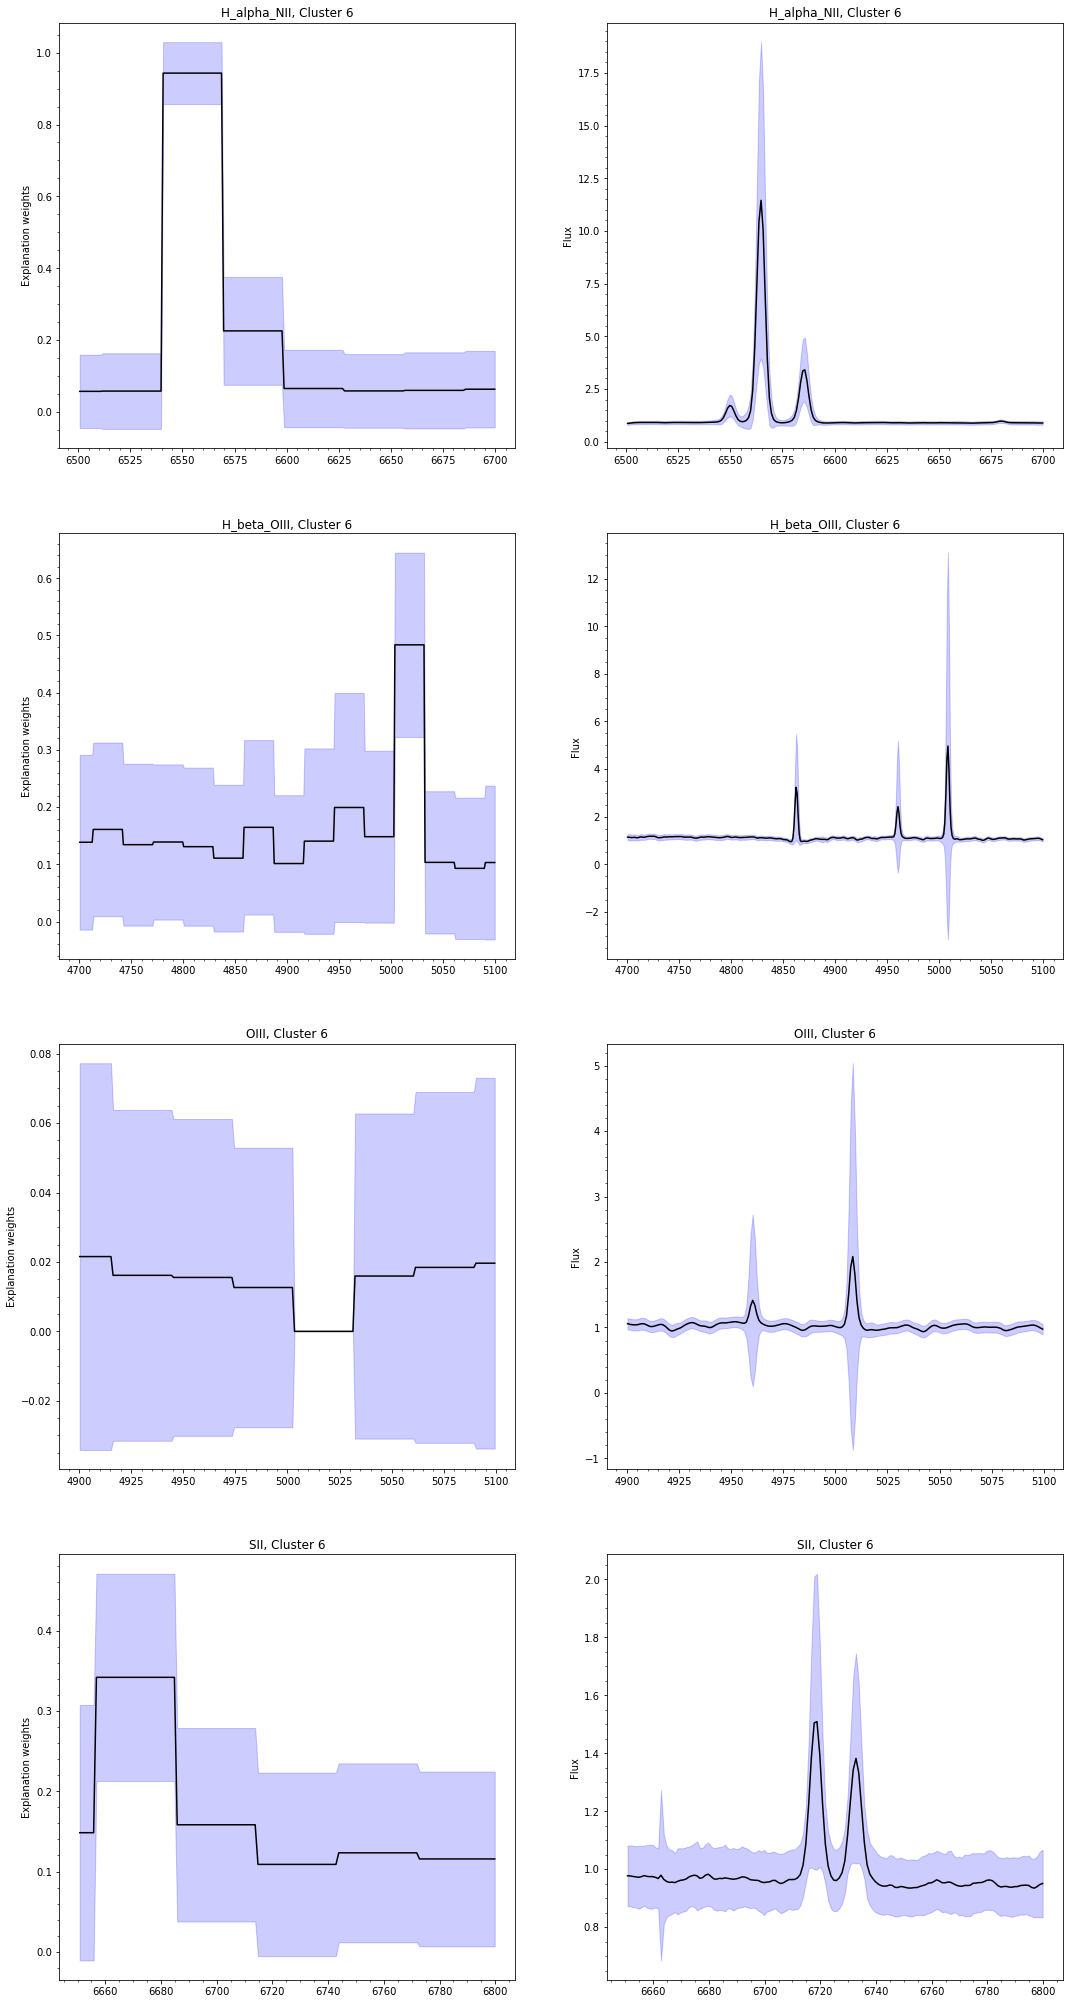

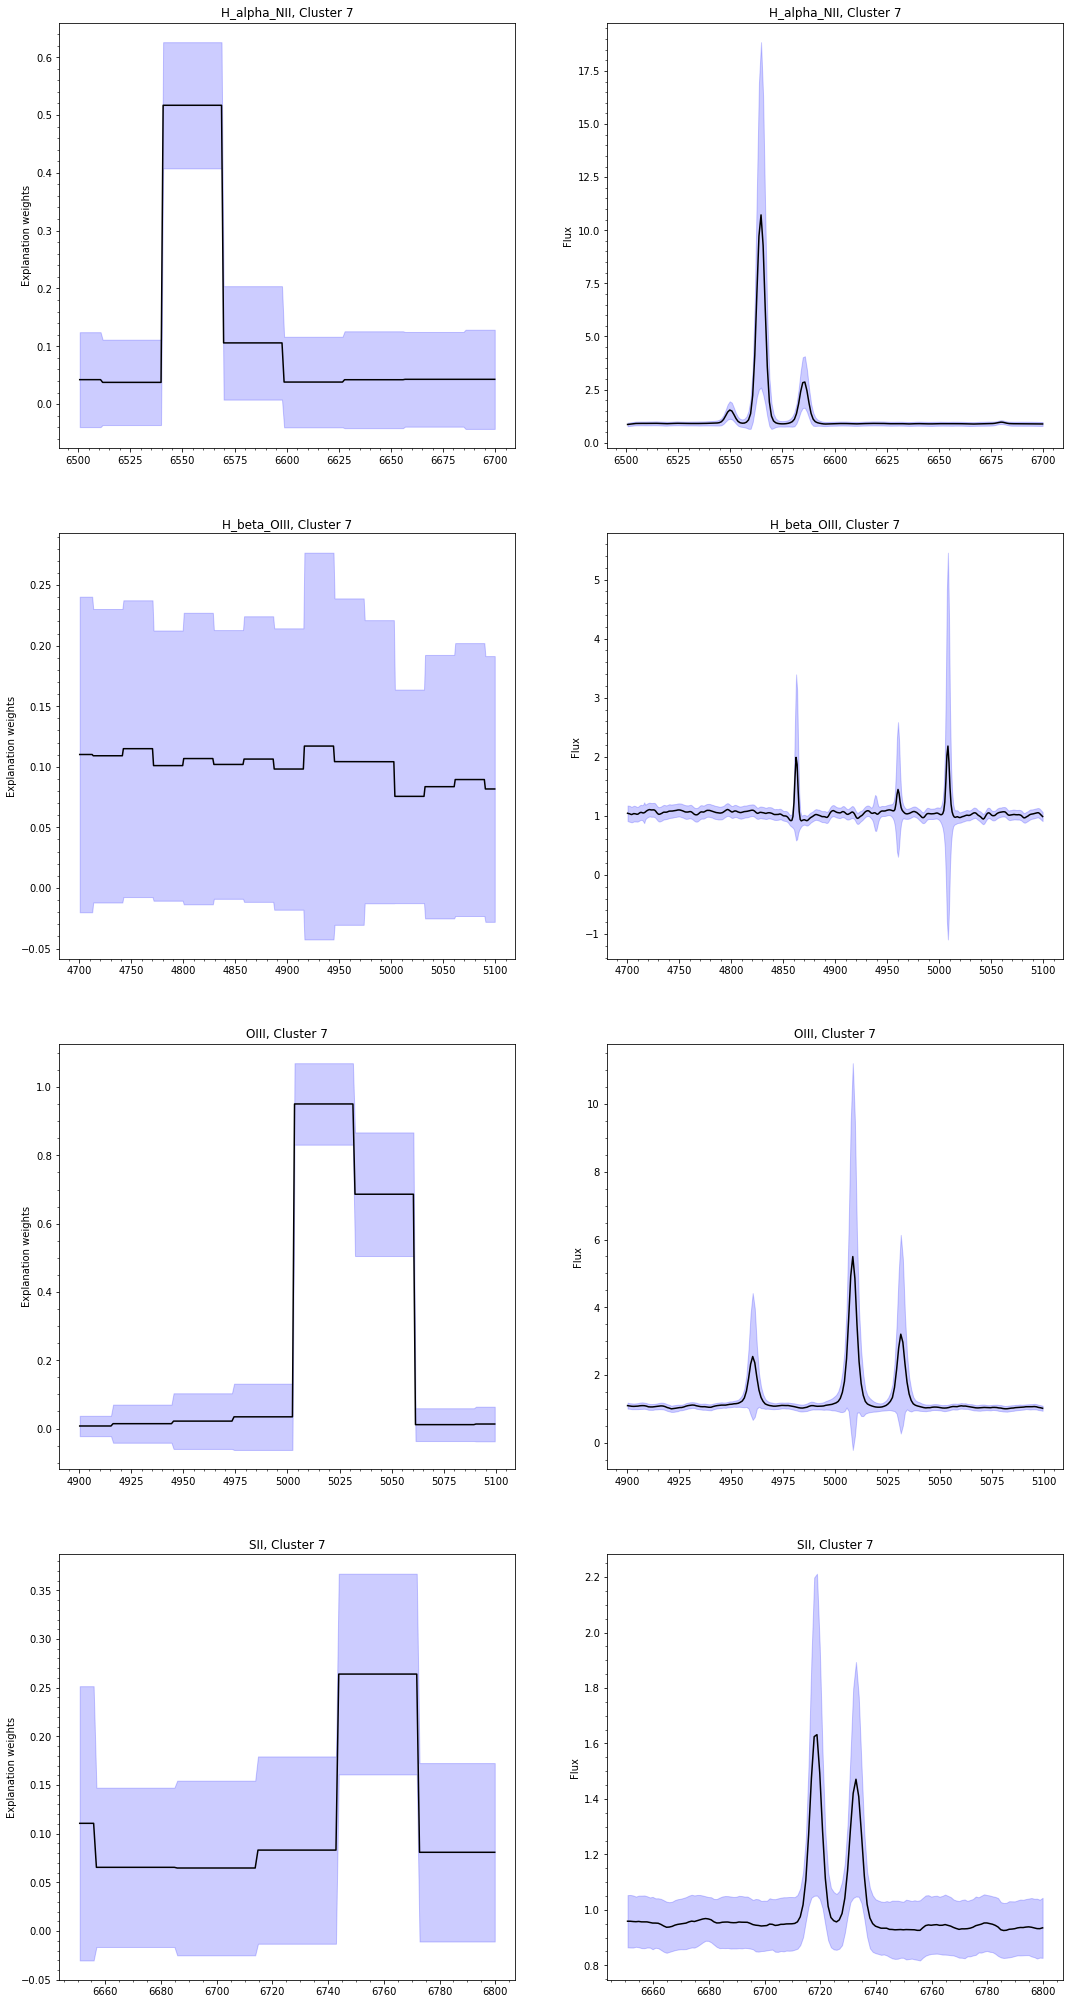

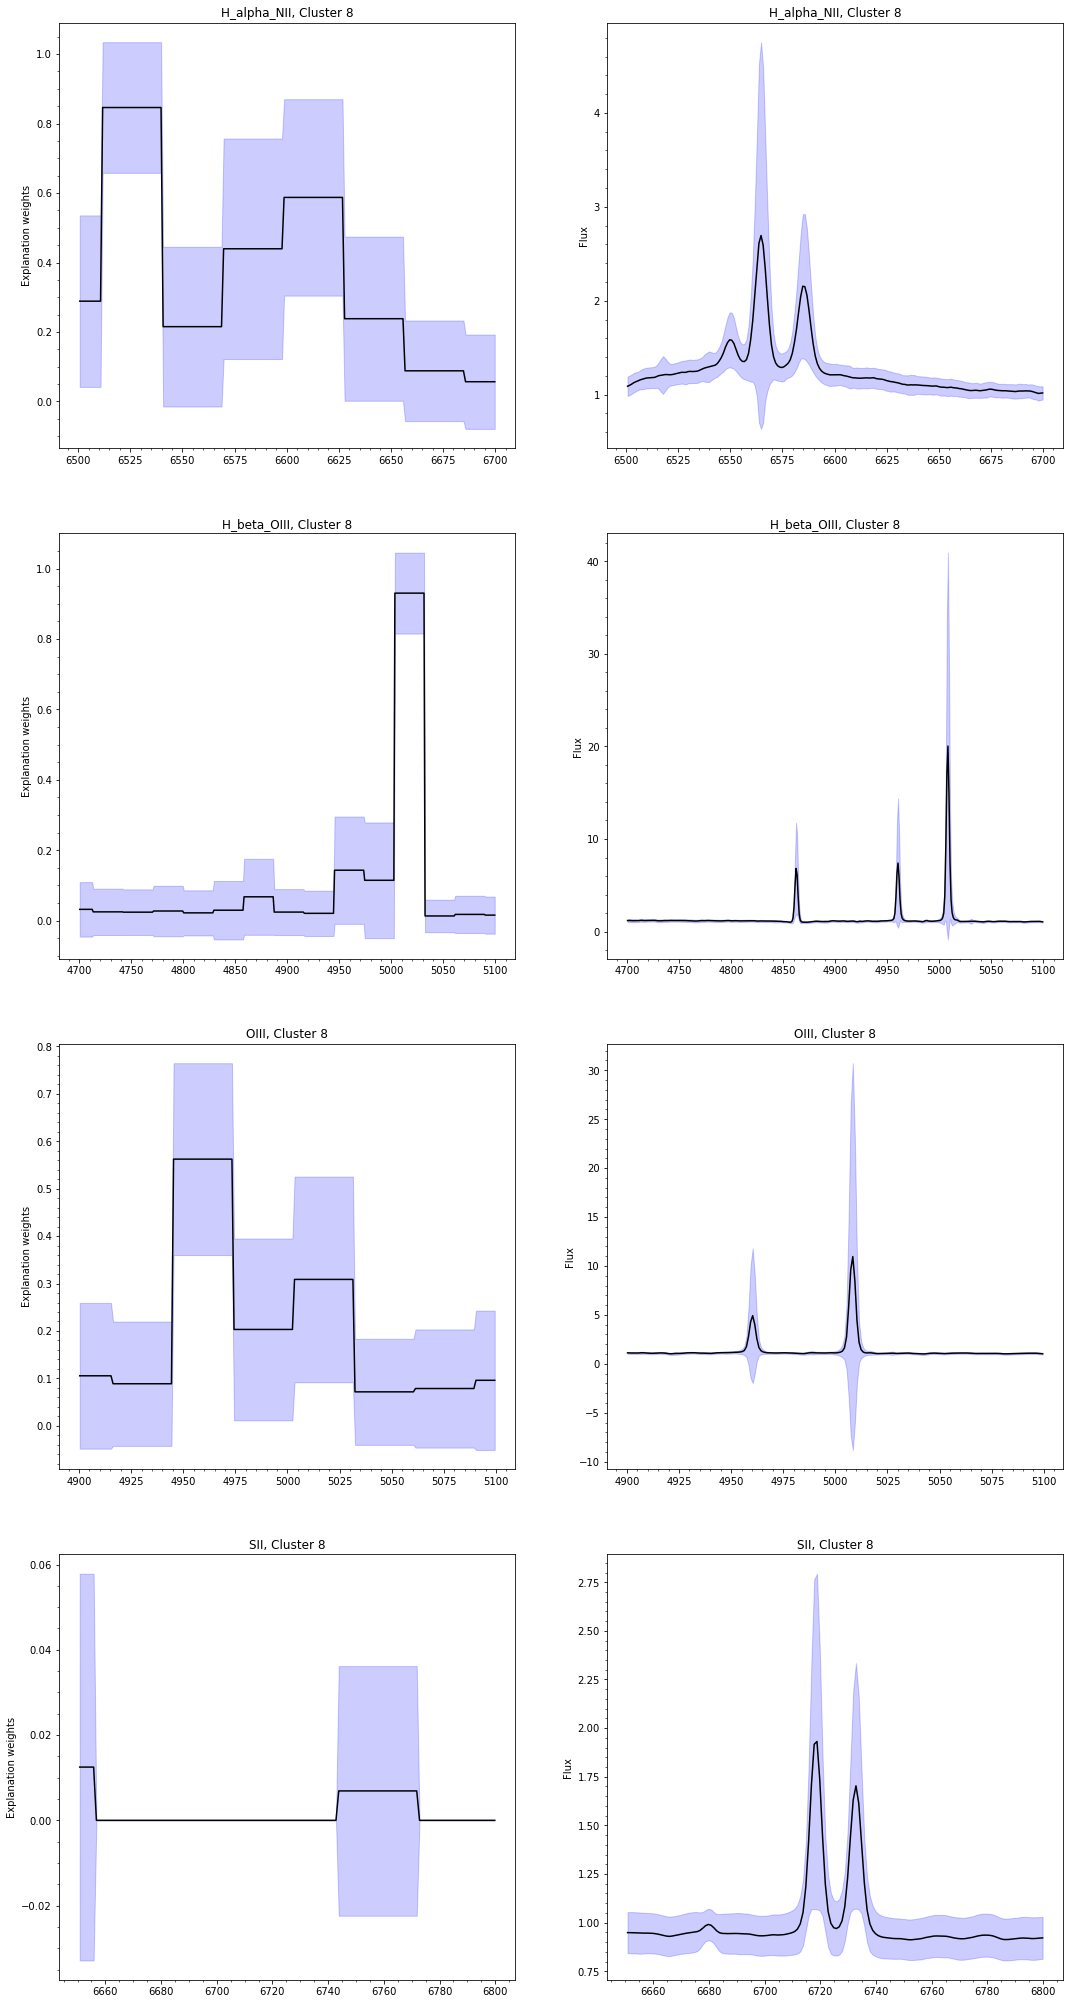

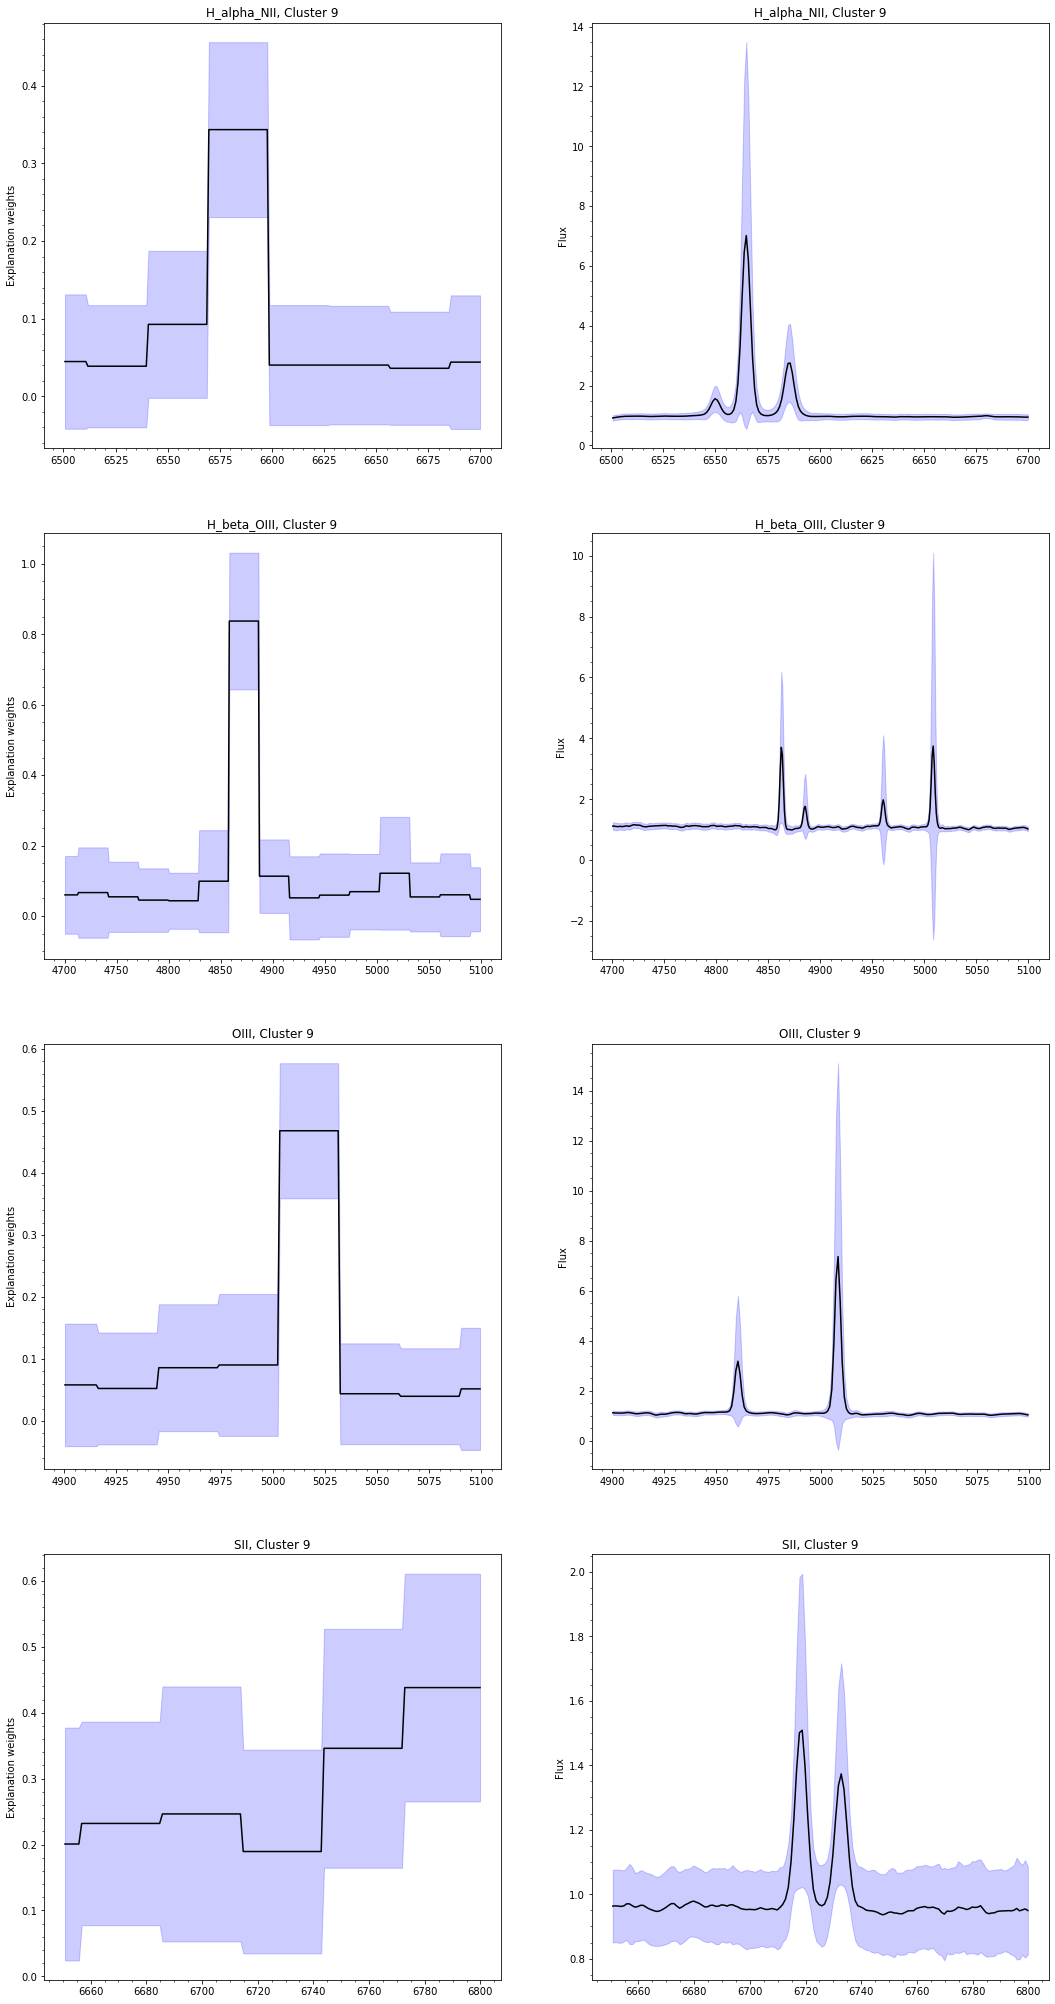

In [17]:
# Set up a figure and axis grid for each cluster
figs, axs = [], []
for c in range(n_clusters):
    fig, ax = plt.subplots(
        nrows=len(regions_of_interest), ncols=2,
        figsize=(18, 36)
    )

    for a in ax.flat:
        a.minorticks_on()

    figs.append(fig)
    axs.append(ax)

# Loop through each region in the dictionary of k-means models
for i, (region_name, (kmeans, region_mask)) in enumerate(kmeans_per_region.items()
):
    # Get the cluster labels for the current line
    cluster_labels = kmeans.predict(weights_per_region[region_name][0])

    # Compute the mean and standard deviation of the weights and anomalies for each cluster
    mean_weights = []
    std_weights = []

    mean_anomalies = []
    std_anomalies = []



    for j in range(n_clusters):
        mask = cluster_labels == j
        mean_weights.append(
            np.mean(weights_per_region[region_name][0][mask], axis=0)
        )
        std_weights.append(
            np.std(weights_per_region[region_name][0][mask], 
            axis=0)
        )

        mean_anomalies.append(
            np.mean(anomalies[:, region_mask][mask], axis=0)
        )

        std_anomalies.append(
            np.std(anomalies[:, region_mask][mask], axis=0)
        )
    
    # Plot the mean explanation weights and mean spectrum for each cluster
    wave_region = wave[region_mask]
    for j in range(n_clusters):
        # Mean explanation weights
        axs[j][i][0].plot(wave_region, mean_weights[j], c='black')
        axs[j][i][0].set_ylabel('Explanation weights')
        axs[j][i][0].set_title(f'{region_name}, Cluster {j}')
        axs[j][i][0].fill_between(
            wave_region,
            mean_weights[j] - std_weights[j],
            mean_weights[j] + std_weights[j],
            alpha=0.2,
            color='blue'
        )

        # Mean spectrum
        axs[j][i][1].plot(wave_region, mean_anomalies[j], c='black')
        axs[j][i][1].set_ylabel('Flux')
        axs[j][i][1].set_title(f'{region_name}, Cluster {j}')
        axs[j][i][1].fill_between(
            wave_region,
            mean_anomalies[j] - std_anomalies[j],
            mean_anomalies[j] + std_anomalies[j],
            alpha=0.2,
            color='blue'
        )

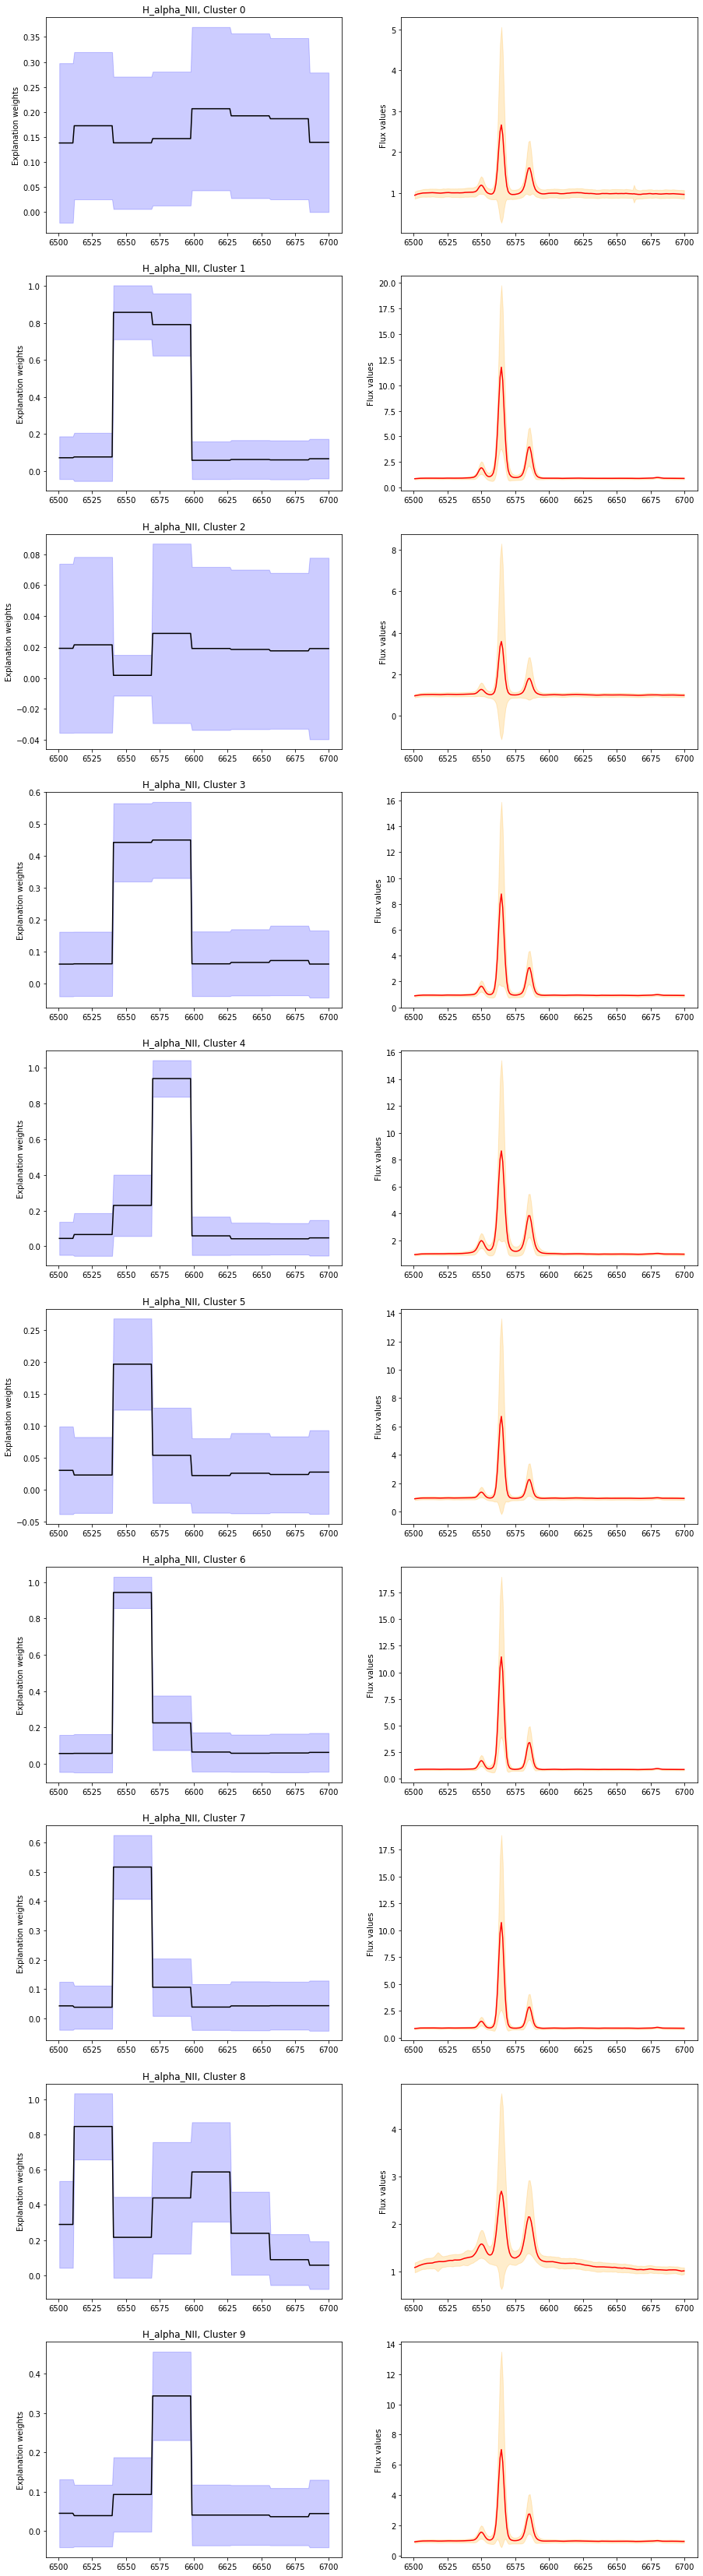

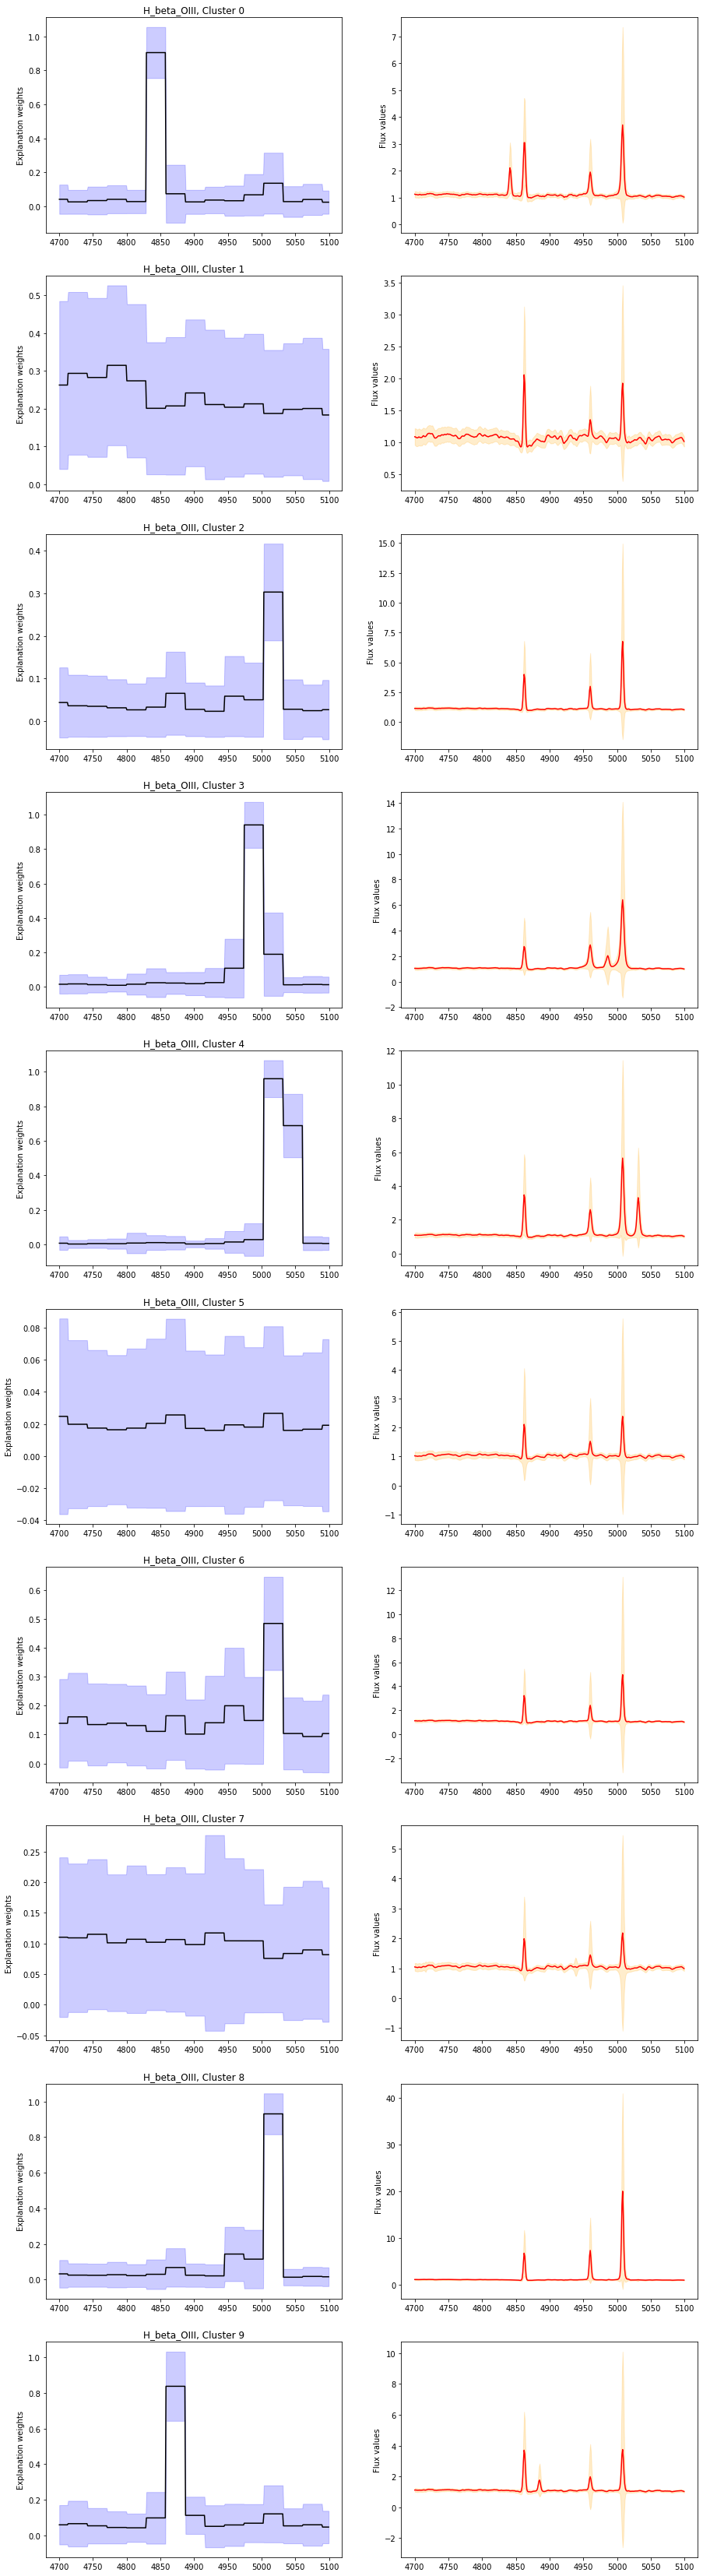

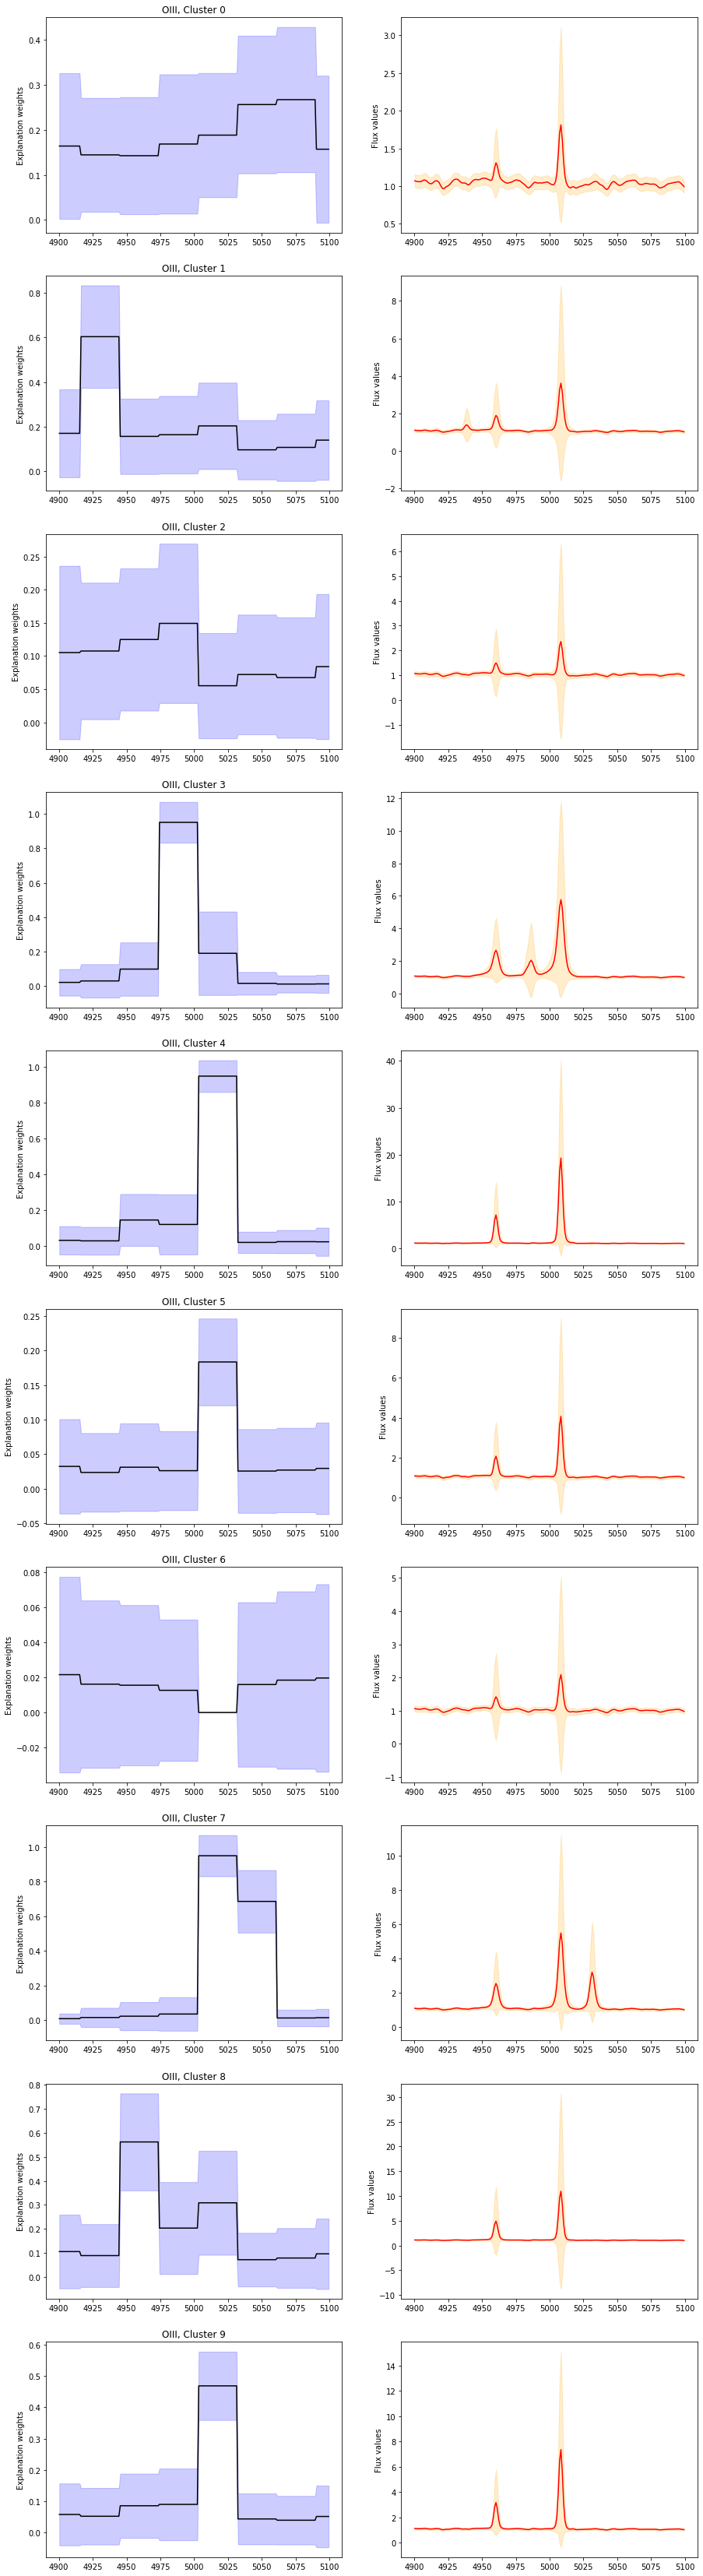

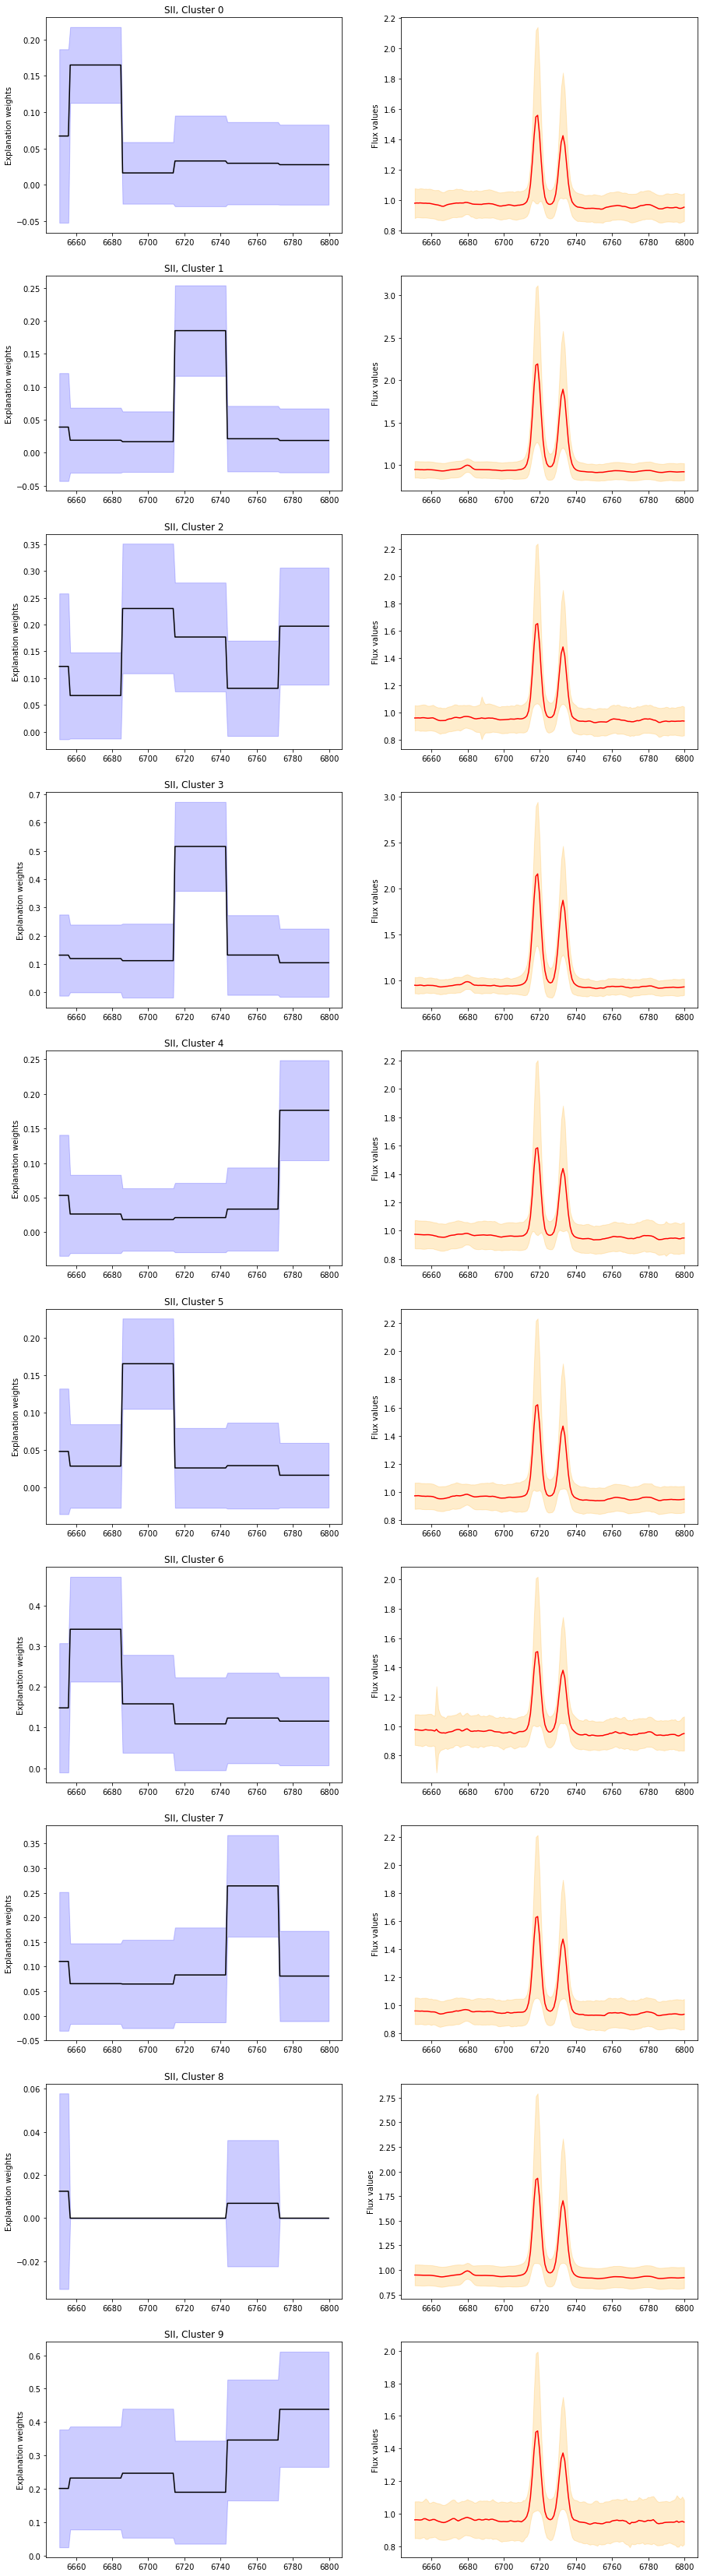

In [19]:
# Set up a figure and axis grid for each line
figs, axs = [], []
for region in regions_of_interest:
    fig, ax = plt.subplots(nrows=n_clusters, ncols=2, figsize=(15, 60))
    figs.append(fig)
    axs.append(ax)

# Loop through each region in the dictionary of k-means models
for i, (region_name, (kmeans, region_mask)) in enumerate(kmeans_per_region.items()):
    # Get the cluster labels for the current line
    cluster_labels = kmeans.predict(weights_per_region[region_name][0])

    # Compute the mean and standard deviation of the weights and anomalies for each cluster
    mean_weights = []
    std_weights = []
    mean_fluxes = []
    std_fluxes = []

    for j in range(n_clusters):
        mask = cluster_labels == j
        mean_weights.append(np.mean(weights_per_region[region_name][0][mask], axis=0))
        std_weights.append(np.std(weights_per_region[region_name][0][mask], axis=0))
        
        mean_fluxes.append(np.mean(anomalies[:,region_mask][mask], axis=0))
        std_fluxes.append(np.std(anomalies[:, region_mask][mask], axis=0))
    
    # Plot the mean explanation weights and flux values for each cluster
    wave_region = wave[region_mask]

    for j in range(n_clusters):

        axs[i][j][0].plot(wave_region, mean_weights[j], c='black')
        axs[i][j][0].set_ylabel('Explanation weights')
        axs[i][j][0].set_title(f'{region_name}, Cluster {j}')
        axs[i][j][0].fill_between(
            wave_region,
            mean_weights[j] - std_weights[j],
            mean_weights[j] + std_weights[j],
            alpha=0.2,
            color='blue'
        )
        axs[i][j][1].plot(wave_region, mean_fluxes[j], c='red')
        axs[i][j][1].set_ylabel('Flux values')
        axs[i][j][1].fill_between(
            wave_region,
            mean_fluxes[j] - std_fluxes[j],
            mean_fluxes[j] + std_fluxes[j],
            alpha=0.2,
            color='orange'
        )

    # save the figure to a file in pdf format with the name of the line in Download directory

    figs[i].savefig(f'/home/edgar/Downloads/{region_name}.pdf', format='pdf')